## GeoEnrichment

This is a key capability you can use in your data science projects. It helps you to get facts about a specific area. The area can be defined by administrative boundaries, or be a result of gemoetric operations such as distance buffer or drive time from a location. Available facts are stored in multiple datasets and reflect population, income, housing, consumer behavior, and the natural environment. Much of the remainder of this notebook is based on https://developers.arcgis.com/python/guide/part1-introduction-to-geoenrichment/ and subsequent documentation sections.

The main method is **enrich()**: it retrieves info for the specified area.
The arcgis.geoenrichment module can help you create geometries to which enrich() can be later applied.

**Examples:** 
    - A wildfire analyst generates a map of the dynamics and extent of forect fires: you need to quickly determine who lives there and what their mobility charatceristics are. 
    - A company is looking for a location of a new store: you need to determine who lives in the vicinity and what they typically buy.

In [1]:
#necessary for python 3.10 since Iterable in collections was depricated in 3.9
#source https://stackoverflow.com/questions/72032032/importerror-cannot-import-name-iterable-from-collections-in-python
# import collections.abc
# #hyper needs the four following aliases to be done manually.
# collections.Iterable = collections.abc.Iterable
# collections.Mapping = collections.abc.Mapping
# collections.MutableSet = collections.abc.MutableSet
# collections.MutableMapping = collections.abc.MutableMapping
# #Now import hyper
# import hyper

In [39]:
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import *
import pandas as pd

#gis = GIS(username='izaslavsky_ucsd')  # this will ask for password. 
print("Enter the Client ID/APP ID generated from Arc GIS:")
app_id = input()
gis = GIS("https://ucsdonline.maps.arcgis.com/home", client_id=app_id)
arcgis.__version__
# Elm5V3upnnV17Q3r

Enter the Client ID/APP ID generated from Arc GIS:


 Elm5V3upnnV17Q3r


Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://ucsdonline.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=Elm5V3upnnV17Q3r&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=RpBrCDYKr8Y09vYRteGTpJ2aizWeG1&allow_verification=false


Enter code obtained on signing in using SAML:  ························································································································································································································


/Users/amolkale/Documents/DSE/DSE260-Capstone-Project/capstone/venv3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ucsdonline.maps.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


'2.1.0'

### What information is available for your country of interest?

In [40]:
%config IPCompleter.greedy=True
# What is available for the US?

usa = Country.get('US')
#usa.properties.datasets

In [3]:
type(usa)

arcgis.geoenrichment.enrichment.Country

### Geoenrichment integrates data from many databases:

* ACS: American Community Survey (https://www.census.gov/programs-surveys/acs, https://doc.arcgis.com/en/esri-demographics/data/acs.htm, http://suave2.sdsc.edu/gallery/sdhhsa)
* ASR: Age, Sex, Race (https://www.census.gov/newsroom/press-kits/2020/population-estimates-detailed.html)
* CRM: Crimes (https://doc.arcgis.com/en/esri-demographics/data/crime-indexes.htm)
* RMP: Retail MarketPlace (https://downloads.esri.com/esri_content_doc/dbl/us/Var_List_Retail-MarketPlace_Summer2020.pdf, https://doc.arcgis.com/en/esri-demographics/data/market-potential.htm)
* Safegraph: 5 million point locations for any transactions (https://www.esri.com/arcgis-blog/products/bus-analyst/data-management/why-and-when-to-use-safegraph-data-in-your-analysis/, https://doc.arcgis.com/en/esri-demographics/data/business.htm)
* Traffic Counts (https://doc.arcgis.com/en/esri-demographics/data/traffic-counts.htm)

Global coverage of geoenrichment: https://doc.arcgis.com/en/arcgis-online/reference/geoenrichment-coverage.htm

Standard geography levels: https://geoenrichdev.arcgis.com/arcgis/rest/services/World/GeoenrichmentServer/Geoenrichment/StandardGeographyLevels

You can also also find variables for geoenrichment with the ESRI Demographics Data Browser at https://doc.arcgis.com/en/esri-demographics/data/data-browser.htm (may be easier!)

In [4]:
# Listing  specific data collections
df = usa.data_collections
df

,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
1yearincrements,1yearincrements.AGE0_CY,2022 Population Age <1,2022 Age: 1 Year Increments (Esri),2022
1yearincrements,1yearincrements.AGE1_CY,2022 Population Age 1,2022 Age: 1 Year Increments (Esri),2022
1yearincrements,1yearincrements.AGE2_CY,2022 Population Age 2,2022 Age: 1 Year Increments (Esri),2022
1yearincrements,1yearincrements.AGE3_CY,2022 Population Age 3,2022 Age: 1 Year Increments (Esri),2022
1yearincrements,1yearincrements.AGE4_CY,2022 Population Age 4,2022 Age: 1 Year Increments (Esri),2022
...,...,...,...,...
yearmovedin,yearmovedin.MOEMEDYRMV,2020 Median Year Householder Moved In MOE (ACS...,2016-2020 Year Householder Moved In (ACS),2016-2020
yearmovedin,yearmovedin.RELMEDYRMV,2020 Median Year Householder Moved In REL (ACS...,2016-2020 Year Householder Moved In (ACS),2016-2020
yearmovedin,yearmovedin.ACSOWNER,2020 Owner Households (ACS 5-Yr),2016-2020 Key Demographic Indicators (ACS),2016-2020


##### USA Country Levels

In [18]:
usa.levels

,level_name,singular_name,plural_name,alias,level_id,admin_level
0,block_groups,Block Group,Block Groups,Block Groups,US.BlockGroups,
1,tracts,Census Tract,Census Tracts,Census Tracts,US.Tracts,
2,places,Place,Places,Cities and Towns (Places),US.Places,
3,zip5,ZIP Code,ZIP Codes,ZIP Codes,US.ZIP5,Admin4
4,csd,County Subdivision,County Subdivisions,County Subdivisions,US.CSD,
5,counties,County,Counties,Counties,US.Counties,Admin3
6,cbsa,CBSA,CBSAs,CBSAs,US.CBSA,
7,cd,Congressional District,Congressional Districts,Congressional Districts,US.CD,
8,dma,DMA,DMAs,DMAs,US.DMA,
9,states,State,States,States,US.States,Admin2


#### Enrichment Variables

In [19]:
usa.enrich_variables

,name,alias,data_collection,enrich_name,enrich_field_name,description,vintage,units
0,AGE0_CY,2022 Population Age <1,1yearincrements,1yearincrements.AGE0_CY,F1yearincrements_AGE0_CY,2022 Total Population Age <1 (Esri),2022,count
1,AGE1_CY,2022 Population Age 1,1yearincrements,1yearincrements.AGE1_CY,F1yearincrements_AGE1_CY,2022 Total Population Age 1 (Esri),2022,count
2,AGE2_CY,2022 Population Age 2,1yearincrements,1yearincrements.AGE2_CY,F1yearincrements_AGE2_CY,2022 Total Population Age 2 (Esri),2022,count
3,AGE3_CY,2022 Population Age 3,1yearincrements,1yearincrements.AGE3_CY,F1yearincrements_AGE3_CY,2022 Total Population Age 3 (Esri),2022,count
4,AGE4_CY,2022 Population Age 4,1yearincrements,1yearincrements.AGE4_CY,F1yearincrements_AGE4_CY,2022 Total Population Age 4 (Esri),2022,count
...,...,...,...,...,...,...,...,...
18941,MOEMEDYRMV,2020 Median Year Householder Moved In MOE (ACS...,yearmovedin,yearmovedin.MOEMEDYRMV,yearmovedin_MOEMEDYRMV,2020 Median Year Householder Moved into Unit M...,2016-2020,count
18942,RELMEDYRMV,2020 Median Year Householder Moved In REL (ACS...,yearmovedin,yearmovedin.RELMEDYRMV,yearmovedin_RELMEDYRMV,2020 Median Year Householder Moved into Unit R...,2016-2020,count
18943,ACSOWNER,2020 Owner Households (ACS 5-Yr),yearmovedin,yearmovedin.ACSOWNER,yearmovedin_ACSOWNER,2020 Owner Households (ACS 5-Yr),2016-2020,count
18944,MOEOWNER,2020 Owner Households MOE (ACS 5-Yr),yearmovedin,yearmovedin.MOEOWNER,yearmovedin_MOEOWNER,2020 Owner Households MOE (ACS 5-Yr),2016-2020,count


#### Travel modes in USA

In [20]:
usa.travel_modes

,name,alias,description,type,impedance,impedance_category,time_attribute_name,distance_attribute_name,travel_mode_id,travel_mode_dict
0,driving_time,Driving Time,Models the movement of cars and other similar ...,AUTOMOBILE,TravelTime,temporal,TravelTime,Kilometers,FEgifRtFndKNcJMJ,"{""attributeParameterValues"": [{""attributeName""..."
1,driving_distance,Driving Distance,Models the movement of cars and other similar ...,AUTOMOBILE,Kilometers,distance,TravelTime,Kilometers,iKjmHuBSIqdEfOVr,"{""attributeParameterValues"": [{""attributeName""..."
2,trucking_time,Trucking Time,Models basic truck travel by preferring design...,TRUCK,TruckTravelTime,temporal,TruckTravelTime,Kilometers,ZzzRtYcPLjXFBKwr,"{""attributeParameterValues"": [{""attributeName""..."
3,trucking_distance,Trucking Distance,Models basic truck travel by preferring design...,TRUCK,Kilometers,distance,TruckTravelTime,Kilometers,UBaNfFWeKcrRVYIo,"{""attributeParameterValues"": [{""attributeName""..."
4,walking_time,Walking Time,Follows paths and roads that allow pedestrian ...,WALK,WalkTime,temporal,WalkTime,Kilometers,caFAgoThrvUpkFBW,"{""attributeParameterValues"": [{""attributeName""..."
5,walking_distance,Walking Distance,Follows paths and roads that allow pedestrian ...,WALK,Kilometers,distance,WalkTime,Kilometers,yFuMFwIYblqKEefX,"{""attributeParameterValues"": [{""attributeName""..."
6,rural_driving_time,Rural Driving Time,Models the movement of cars and other similar ...,AUTOMOBILE,TravelTime,temporal,TravelTime,Kilometers,NmNhNDUwZmE1YTlj,"{""attributeParameterValues"": [{""attributeName""..."
7,rural_driving_distance,Rural Driving Distance,Models the movement of cars and other similar ...,AUTOMOBILE,Kilometers,distance,TravelTime,Kilometers,Yzk3NjI1NTU5NjVj,"{""attributeParameterValues"": [{""attributeName""..."


In [21]:
# Discover named geographies and level of detail

#sandiego_in_usa = usa.search('San Diego')
#print("number of San Diego's in the US: " + str(len(sandiego_in_usa)))

# list a few of them
#sandiego_in_usa[:30]

In [22]:
#type(sandiego_in_usa[0])



#### Available enrichment reports on usa data collection

In [23]:
usa.reports

,id,title,categories,formats
0,census2010_profile,2010 Census Profile,[Demographics],"[pdf, xlsx]"
1,acs_housing,ACS Housing Summary,[Demographics],"[pdf, xlsx]"
2,acs_keyfacts,ACS Key Population & Household Facts,[Demographics],"[pdf, xlsx]"
3,acs_population,ACS Population Summary,[Demographics],"[pdf, xlsx]"
4,55plus,Age 50+ Profile,[Demographics],"[pdf, xlsx]"
5,agesexrace,Age by Sex by Race Profile,[Demographics],"[pdf, xlsx]"
6,agesex,Age by Sex Profile,[Demographics],"[pdf, xlsx]"
7,cex_auto,Automotive Aftermarket Expenditures,[Consumer Spending],"[pdf, xlsx]"
8,business_loc,Business Locator,[Business],"[pdf, xlsx]"
9,business_summary,Business Summary,[Business],"[pdf, xlsx]"


In [24]:
#usa.subgeographies.states.values()

In [ ]:
list(usa.subgeographies.cbsa.values())[:10]

In [ ]:
# let's put them on a map
#usamap = gis.map('United States', zoomlevel=4)
#usamap

In [ ]:
imperial_in_usa = usa.search("Imperial")

*CDP here stands for census designated places. Census designated places (CDPs) are statistical geographic entities representing closely settled, unincorporated communities that are locally recognized and identified by name. They are the statistical equivalents of incorporated places, with the primary differences being the lack of a legally defined boundary and an active, functioning governmental structure.*

In [ ]:
%config IPCompleter.greedy=True
ca_places = usa.subgeographies.states['California'].places
#ca_places

In [5]:
ca_places_list = list(ca_places.values())

In [6]:
ca_places_list[:10]

[<NamedArea name:"United States" area_id="0600135", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600156", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600212", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600296", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600310", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600394", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600450", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600464", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600478", level="US.Places", country="United States">,
 <NamedArea name:"United States" area_id="0600535", level="US.Places", country="United States">]

# Geocoding

In [12]:
from arcgis.geocoding import Geocoder, get_geocoders

my_geocoder = get_geocoders(gis)[0]
my_geocoder

<Geocoder url:"https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer">

In [14]:
# Properties of the geocoder class
[prop_name for prop_name in my_geocoder.properties.keys()]

['currentVersion',
 'serviceDescription',
 'addressFields',
 'categories',
 'singleLineAddressField',
 'candidateFields',
 'spatialReference',
 'locatorProperties',
 'detailedCountries',
 'countries',
 'capabilities']

In [13]:
# Exploring addressFields property
for addr_fld in my_geocoder.properties.addressFields:
    print(addr_fld['name'] + " (" + str(addr_fld['length']) +" chars)")

Address (100 chars)
Address2 (100 chars)
Address3 (100 chars)
Neighborhood (50 chars)
City (50 chars)
Subregion (50 chars)
Region (50 chars)
Postal (20 chars)
PostalExt (20 chars)
CountryCode (100 chars)


In [18]:
# Exploring categories.`Populated Place` property
categories = my_geocoder.properties['categories']


In [26]:
categories[3]['categories'][2]

{'name': 'Neighborhood',
 'localizedNames': {'ar': 'مجاورة',
  'bg': 'Квартал',
  'bs': 'Četvrt',
  'ca': 'Barri',
  'cs': 'Čtvrť',
  'da': 'Lokalområde',
  'de': 'Nachbarschaft',
  'el': 'Γειτονιά',
  'en': 'Neighborhood',
  'es': 'Barrio',
  'et': 'Linnaosa',
  'fi': 'Kaupunginosa',
  'fr': 'Quartier',
  'he': 'שכונה',
  'hi': 'आस-पड़ोस',
  'hr': 'Četvrt',
  'hu': 'Szomszédság',
  'id': 'Lingkungan',
  'it': 'Vicinato',
  'ja': '近郊',
  'ko': '네이버후드',
  'lt': 'Apylinkė',
  'lv': 'Apkārtne',
  'nb': 'Nabolag',
  'nl': 'Omgeving',
  'pl': 'Dzielnica',
  'pt-br': 'Bairro',
  'pt-pt': 'Bairro',
  'ro': 'Cartier',
  'ru': 'Район',
  'sk': 'Susedstvo',
  'sl': 'Soseska',
  'sr': 'Susedstvo',
  'sv': 'Grannskap',
  'th': 'บริเวณใกล้เคียง',
  'tr': 'Komşu',
  'uk': 'Район',
  'vi': 'Vùng lân cận',
  'zh-cn': '住宅区',
  'zh-hk': '街區',
  'zh-tw': '街區'}}

#### *Let's try to do reverse geocoding to get details such as neighbourhood from a geometry object*

In [41]:
block_groups_dict = usa.subgeographies.states['California'].counties['San_Diego_County'].block_groups
block_groups_list = list(block_groups_dict.values())

In [42]:
sample_block_group = block_groups_list[0]

In [43]:
print(sample_block_group)

<NamedArea name:"United States" area_id="060730009011", level="US.BlockGroups", country="United States">


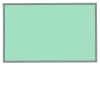

In [44]:
# According to below link we can reverse geocode a geometry:
# https://developers.arcgis.com/python/guide/part5-reverse-geocoding/#example-4---location-input-as-point-geometry-object

sample_block_group_geometry = sample_block_group.geometry
sample_block_group_geometry

In [47]:
sample_block_group_geometry.spatial_reference

{'wkid': 4326, 'latestWkid': 4326}

In [45]:
from arcgis.geometry import Geometry
from arcgis.geocoding import reverse_geocode

In [48]:
## Example 1 - location input as list
reverse_geocode([2.2945, 48.8583])

{'address': {'Match_addr': 'Tour Eiffel',
  'LongLabel': 'Tour Eiffel, Paris, Île-de-France, FRA',
  'ShortLabel': 'Tour Eiffel',
  'Addr_type': 'POI',
  'Type': 'Historical Monument',
  'PlaceName': 'Tour Eiffel',
  'AddNum': '',
  'Address': '',
  'Block': '',
  'Sector': '',
  'Neighborhood': 'Paris 07',
  'District': 'Paris',
  'City': 'Paris',
  'MetroArea': '',
  'Subregion': 'Paris',
  'Region': 'Île-de-France',
  'RegionAbbr': '',
  'Territory': '',
  'Postal': '',
  'PostalExt': '',
  'CntryName': 'France',
  'CountryCode': 'FRA'},
 'location': {'x': 2.294520000000034,
  'y': 48.85832000000005,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}}

In [49]:
## Example 2 - location input as dict
reverse_geocode(location={"x": 103.876722, "y": 1.3330736})

{'address': {'Match_addr': 'Sennett Estate, 40 Lichi Avenue, 348814, Singapore',
  'LongLabel': 'Sennett Estate, 40 Lichi Avenue, 348814, Singapore, SGP',
  'ShortLabel': 'Sennett Estate, 40 Lichi Avenue',
  'Addr_type': 'PointAddress',
  'Type': '',
  'PlaceName': '',
  'AddNum': '40',
  'Address': 'Sennett Estate, 40 Lichi Avenue',
  'Block': '',
  'Sector': '',
  'Neighborhood': '',
  'District': '',
  'City': 'Singapore',
  'MetroArea': '',
  'Subregion': '',
  'Region': 'Singapore',
  'RegionAbbr': '',
  'Territory': '',
  'Postal': '348814',
  'PostalExt': '',
  'CntryName': 'Singapore',
  'CountryCode': 'SGP'},
 'location': {'x': 103.87671885261159,
  'y': 1.333058719212687,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}}

In [50]:
## Example 3 - location input as dict with sr
reverse_geocode(location= { "x": 11563503, "y": 148410, "spatialReference": { "wkid": 3857 } })

{'address': {'Match_addr': 'Sennett Estate, 40 Lichi Avenue, 348814, Singapore',
  'LongLabel': 'Sennett Estate, 40 Lichi Avenue, 348814, Singapore, SGP',
  'ShortLabel': 'Sennett Estate, 40 Lichi Avenue',
  'Addr_type': 'PointAddress',
  'Type': '',
  'PlaceName': '',
  'AddNum': '40',
  'Address': 'Sennett Estate, 40 Lichi Avenue',
  'Block': '',
  'Sector': '',
  'Neighborhood': '',
  'District': '',
  'City': 'Singapore',
  'MetroArea': '',
  'Subregion': '',
  'Region': 'Singapore',
  'RegionAbbr': '',
  'Territory': '',
  'Postal': '348814',
  'PostalExt': '',
  'CntryName': 'Singapore',
  'CountryCode': 'SGP'},
 'location': {'x': 103.87671885261159,
  'y': 1.333058719212687,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}}

In [51]:
## Example 4 - location input as Point Geometry object
from arcgis.geometry import Geometry

pt = Geometry({
    "x": 11563503,
    "y": 148410,
    "spatialReference": {
        "wkid": 3857
    }
})

reverse_geocode(pt)

{'address': {'Match_addr': 'Sennett Estate, 40 Lichi Avenue, 348814, Singapore',
  'LongLabel': 'Sennett Estate, 40 Lichi Avenue, 348814, Singapore, SGP',
  'ShortLabel': 'Sennett Estate, 40 Lichi Avenue',
  'Addr_type': 'PointAddress',
  'Type': '',
  'PlaceName': '',
  'AddNum': '40',
  'Address': 'Sennett Estate, 40 Lichi Avenue',
  'Block': '',
  'Sector': '',
  'Neighborhood': '',
  'District': '',
  'City': 'Singapore',
  'MetroArea': '',
  'Subregion': '',
  'Region': 'Singapore',
  'RegionAbbr': '',
  'Territory': '',
  'Postal': '348814',
  'PostalExt': '',
  'CntryName': 'Singapore',
  'CountryCode': 'SGP'},
 'location': {'x': 103.87671885261159,
  'y': 1.333058719212687,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}}

In [ ]:
reverse_geocode()

In [64]:
#results = reverse_geocode(sample_block_group_geometry)

In [55]:
sample_block_group_geometry.coordinates

<bound method Polygon.coordinates of {'rings': [[[-117.13760189952215, 32.75528776695715], [-117.1375979002225, 32.754661766698355], [-117.13759189947642, 32.754045766913016], [-117.13758389997878, 32.752562766146006], [-117.13758289925558, 32.75219376655487], [-117.13783089985101, 32.752191766747465], [-117.13820489994481, 32.75219176599195], [-117.13857489984068, 32.75218876665844], [-117.1388228995378, 32.752189766184436], [-117.13943689983113, 32.75218876665844], [-117.13981089992492, 32.75218576656934], [-117.14005889962205, 32.75218676609542], [-117.14129389988139, 32.752182766480175], [-117.14190290015183, 32.752177765827575], [-117.14253690053667, 32.75217676630145], [-117.14253490088683, 32.75254776651799], [-117.14252990086396, 32.754034766311506], [-117.1425389010848, 32.75501876666705], [-117.14254190055952, 32.75526576681512], [-117.1422939008624, 32.755264766568104], [-117.1419049007, 32.7552677665535], [-117.14154990087273, 32.7552677665535], [-117.14007990043676, 32.755

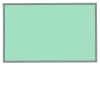

In [63]:
sample_block_group_geometry

In [57]:
sample_block_group_geometry_coord = sample_block_group_geometry.centroid

In [65]:
sample_block_group_geometry_coord

(-117.14006181061681, 32.753729590544694)

In [58]:
sample_block_group_geometry_coord[0]

-117.14006181061681

In [59]:
reverse_geocode(location={"x": sample_block_group_geometry_coord[0], "y": sample_block_group_geometry_coord[1]})

{'address': {'Match_addr': '4101-4199 Louisiana St, San Diego, California, 92104',
  'LongLabel': '4101-4199 Louisiana St, San Diego, CA, 92104, USA',
  'ShortLabel': '4101-4199 Louisiana St',
  'Addr_type': 'StreetAddress',
  'Type': '',
  'PlaceName': '',
  'AddNum': '4183',
  'Address': '4183 Louisiana St',
  'Block': '',
  'Sector': '',
  'Neighborhood': 'University Heights',
  'District': '',
  'City': 'San Diego',
  'MetroArea': 'San Diego Metro Area',
  'Subregion': 'San Diego County',
  'Region': 'California',
  'RegionAbbr': 'CA',
  'Territory': '',
  'Postal': '92104',
  'PostalExt': '',
  'CntryName': 'United States',
  'CountryCode': 'USA'},
 'location': {'x': -117.13999868057684,
  'y': 32.75373026683692,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}}

In [60]:
reverse_geocode(location=[-117.13758289925558,32.75219376655487])

{'address': {'Match_addr': '4101-4199 Arizona St, San Diego, California, 92104',
  'LongLabel': '4101-4199 Arizona St, San Diego, CA, 92104, USA',
  'ShortLabel': '4101-4199 Arizona St',
  'Addr_type': 'StreetAddress',
  'Type': '',
  'PlaceName': '',
  'AddNum': '4103',
  'Address': '4103 Arizona St',
  'Block': '',
  'Sector': '',
  'Neighborhood': 'North Park',
  'District': '',
  'City': 'San Diego',
  'MetroArea': 'San Diego Metro Area',
  'Subregion': 'San Diego County',
  'Region': 'California',
  'RegionAbbr': 'CA',
  'Territory': '',
  'Postal': '92104',
  'PostalExt': '',
  'CntryName': 'United States',
  'CountryCode': 'USA'},
 'location': {'x': -117.13753165382987,
  'y': 32.75219349466554,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}}

In [61]:
sample_block_group.geometry.geometry_type

'polygon'

In [62]:
sample_block_group.geometry.true_centroid

(-117.14006181061681, 32.753729590544694)